<a href="https://colab.research.google.com/github/soom1nb/Introduction-to-Computer-Vision/blob/main/knn(CIFAR_10).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **[Introduction to Computer Vision]**
## K-Nearest Neighbors on CIFAR-10  
### Student: Baik Soo Min  
### Student ID: 2022112338  
### Major: Data Science  

# **0. Import**

In [6]:
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import KFold
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

# **1. CIFAR-10 download & preprocessing**
- Images are flattened from (32,32,3) -> (3072,)
- Normalize pixel values from 0-255 to 0-1
- Xtr, Ytr : train features and labels
- Xte, Yte : test features and labels

In [7]:
transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Xtr = train_dataset.data.reshape(50000, -1).astype(np.float32) / 255.0
Ytr = np.array(train_dataset.targets)
Xte = test_dataset.data.reshape(10000, -1).astype(np.float32) / 255.0
Yte = np.array(test_dataset.targets)

# **2. Vectorized Nearest Neighbor Classifier**
- Vectorization for computing more fast
- train method:
  - Store training data and labels
- predict method:
  - Compute L2 distance


In [8]:
class NearestNeighborVectorized:
    def __init__(self):
        pass

    def train(self, X, y):
        self.Xtr = X
        self.ytr = y

    def predict(self, X, k=1):
        # Vectorized L2 distance
        dists = np.sqrt(
            np.sum(X**2, axis=1, keepdims=True) +
            np.sum(self.Xtr**2, axis=1) -
            2 * X.dot(self.Xtr.T)
        )
        nearest_idx = np.argsort(dists, axis=1)[:, :k]
        Ypred = np.array([np.bincount(self.ytr[idx]).argmax() for idx in nearest_idx])
        return Ypred

# **3. Train/Test Split only**
- Predict labels on the test data using a chosen k = 1
- Metrics : accuracy, precision, recall, F1-score

In [9]:
nn = NearestNeighborVectorized()
nn.train(Xtr, Ytr)
Yte_pred = nn.predict(Xte, k=1)

print("=== Train/Test metrics ===")
print("Accuracy:", accuracy_score(Yte, Yte_pred))
print("Precision:", precision_score(Yte, Yte_pred, average='macro'))
print("Recall:", recall_score(Yte, Yte_pred, average='macro'))
print("F1-score:", f1_score(Yte, Yte_pred, average='macro'))

=== Train/Test metrics ===
Accuracy: 0.3539
Precision: 0.41122464684632654
Recall: 0.3539
F1-score: 0.3494752122873106


# **4. Validation split for hyperparameter tuning**
- Split the original train set into
  - Train subset : 49,000 samples
  - Validation set : 1,000 samples
- Use Validation set to select the best value of k based on accuracy

[Code result]
- best value of k : 5

In [10]:
Xval = Xtr[:1000]
Yval = Ytr[:1000]
Xtr_sub = Xtr[1000:]
Ytr_sub = Ytr[1000:]

validation_accuracies = []
k_values = [1, 3, 5, 10, 20, 50, 100]

for k in k_values:
    nn = NearestNeighborVectorized()
    nn.train(Xtr_sub, Ytr_sub)

    # Vectorized prediction for validation set
    dists_val = np.sqrt(
        np.sum(Xval**2, axis=1, keepdims=True) +
        np.sum(Xtr_sub**2, axis=1) -
        2 * Xval.dot(Xtr_sub.T)
    )

    # tqdm for tracking progress per sample
    Yval_pred = []
    for row in tqdm(dists_val, desc=f"Validation prediction (k={k})", total=dists_val.shape[0]):
        nearest_idx = np.argsort(row)[:k]
        nearest_labels = Ytr_sub[nearest_idx]
        Yval_pred.append(np.bincount(nearest_labels).argmax())
    Yval_pred = np.array(Yval_pred)

    acc = accuracy_score(Yval, Yval_pred)
    validation_accuracies.append((k, acc))
    print(f"Validation accuracy (k={k}): {acc:.4f}")

best_k = max(validation_accuracies, key=lambda x: x[1])[0]
print("Best k:", best_k)

# Test with best k
nn.train(Xtr_sub, Ytr_sub)
Yte_pred = nn.predict(Xte, k=best_k)
print("\n=== Test metrics with best k ===")
print("Accuracy:", accuracy_score(Yte, Yte_pred))
print("Precision:", precision_score(Yte, Yte_pred, average='macro'))
print("Recall:", recall_score(Yte, Yte_pred, average='macro'))
print("F1-score:", f1_score(Yte, Yte_pred, average='macro'))


Validation prediction (k=1): 100%|██████████| 1000/1000 [00:01<00:00, 894.18it/s]


Validation accuracy (k=1): 0.3520


Validation prediction (k=3): 100%|██████████| 1000/1000 [00:02<00:00, 492.84it/s]


Validation accuracy (k=3): 0.3390


Validation prediction (k=5): 100%|██████████| 1000/1000 [00:01<00:00, 906.60it/s]


Validation accuracy (k=5): 0.3540


Validation prediction (k=10): 100%|██████████| 1000/1000 [00:01<00:00, 912.09it/s]


Validation accuracy (k=10): 0.3530


Validation prediction (k=20): 100%|██████████| 1000/1000 [00:01<00:00, 775.17it/s]


Validation accuracy (k=20): 0.3340


Validation prediction (k=50): 100%|██████████| 1000/1000 [00:01<00:00, 909.89it/s]


Validation accuracy (k=50): 0.3120


Validation prediction (k=100): 100%|██████████| 1000/1000 [00:01<00:00, 868.25it/s]


Validation accuracy (k=100): 0.3020
Best k: 5

=== Test metrics with best k ===
Accuracy: 0.3395
Precision: 0.4285360258758761
Recall: 0.33949999999999997
F1-score: 0.32562881723828874


# **5. 5-Fold Cross-Validation**
- Split the dataset into 5 folds
- k_values = [1, 3, 5, 10, 20, 50, 100]


In [12]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {k: [] for k in k_values}

# 5-Fold
for k in k_values:
    print(f"\nProcessing k={k}")
    for train_idx, val_idx in tqdm(kf.split(Xtr), total=5, desc=f"k={k} folds"):
        X_train_cv, X_val_cv = Xtr[train_idx], Xtr[val_idx]
        Y_train_cv, Y_val_cv = Ytr[train_idx], Ytr[val_idx]

        nn = NearestNeighborVectorized()
        nn.train(X_train_cv, Y_train_cv)
        Y_val_pred = nn.predict(X_val_cv, k=k)

        cv_results[k].append(accuracy_score(Y_val_cv, Y_val_pred))

print("\n=== k values CV Performance ===")
for k in k_values:
    mean_acc = np.mean(cv_results[k])
    std_acc = np.std(cv_results[k])
    print(f"k={k}: Mean CV Accuracy = {mean_acc:.4f}, Std = {std_acc:.4f}")


Processing k=1


k=1 folds: 100%|██████████| 5/5 [02:43<00:00, 32.62s/it]



Processing k=3


k=3 folds: 100%|██████████| 5/5 [02:42<00:00, 32.59s/it]



Processing k=5


k=5 folds: 100%|██████████| 5/5 [02:37<00:00, 31.57s/it]



Processing k=10


k=10 folds: 100%|██████████| 5/5 [02:38<00:00, 31.61s/it]



Processing k=20


k=20 folds: 100%|██████████| 5/5 [02:35<00:00, 31.02s/it]



Processing k=50


k=50 folds: 100%|██████████| 5/5 [02:38<00:00, 31.77s/it]



Processing k=100


k=100 folds: 100%|██████████| 5/5 [02:37<00:00, 31.55s/it]


=== k values CV Performance ===
k=1: Mean CV Accuracy = 0.3411, Std = 0.0050
k=3: Mean CV Accuracy = 0.3232, Std = 0.0049
k=5: Mean CV Accuracy = 0.3320, Std = 0.0049
k=10: Mean CV Accuracy = 0.3289, Std = 0.0047
k=20: Mean CV Accuracy = 0.3245, Std = 0.0059
k=50: Mean CV Accuracy = 0.3085, Std = 0.0042
k=100: Mean CV Accuracy = 0.2960, Std = 0.0028


# **6. Plot Cross-Validation performance**
- Plot accuracy vs k with error bars

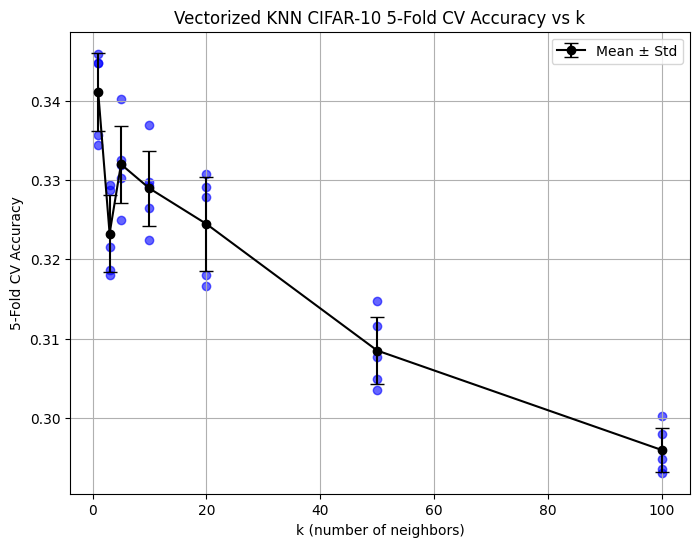

In [16]:
plt.figure(figsize=(8,6))

for k in k_values:
    y = cv_results[k]
    x = [k] * len(y)
    plt.scatter(x, y, color='blue', alpha=0.6)

cv_mean = [np.mean(cv_results[k]) for k in k_values]
cv_std = [np.std(cv_results[k]) for k in k_values]
plt.errorbar(k_values, cv_mean, yerr=cv_std, fmt='-o', color='black', capsize=5, label='Mean ± Std')

plt.xlabel('k (number of neighbors)')
plt.ylabel('5-Fold CV Accuracy')
plt.title('Vectorized KNN CIFAR-10 5-Fold CV Accuracy vs k')
plt.grid(True)
plt.legend()
plt.show()
